In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

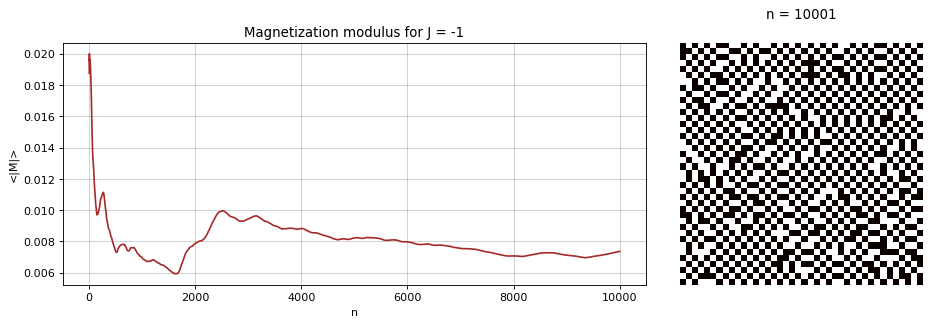

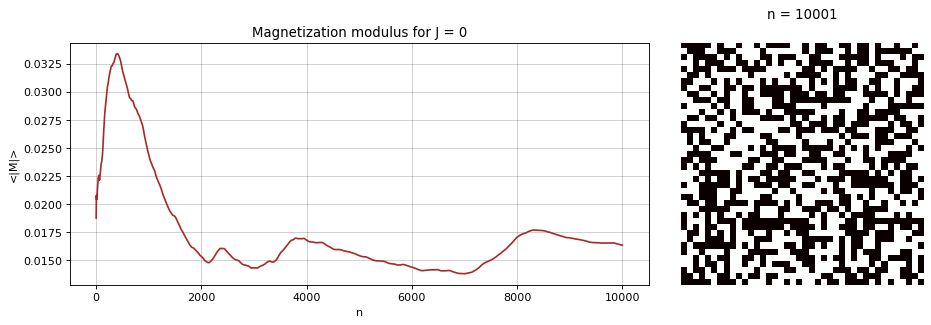

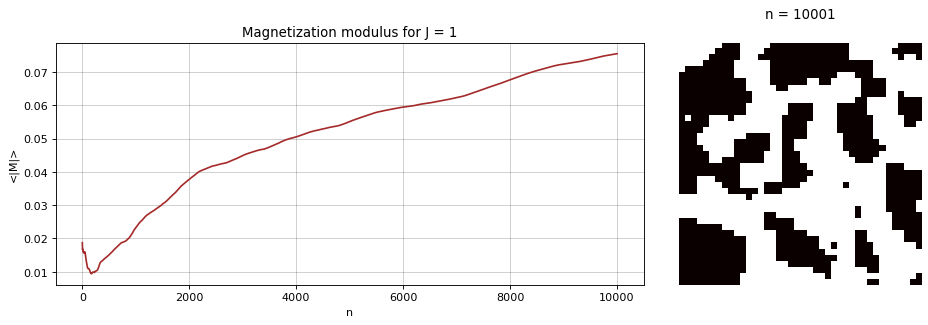

In [97]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 0.5

# Create initial grid
id_grid_0 = np.zeros((nx + 2, nx + 2))
id_grid_0[1:-1, 1:-1] = np.random.choice([-1, 1], (nx,nx))


def Ising_model(J):
    # Create grid
    grid = id_grid_0.copy()
    
    # Create list to store Magnetization modulus
    M = np.zeros(n_steps + 1)
    
    for step in range(n_steps):
        
        # Randomly choose lattice site 
        M[step:] += abs(np.sum(grid))
        i, j = np.random.randint(1,41, 2)

        # Hamiltonian
        H = J*(grid[i - 1, j] + grid[i + 1, j] + grid[i, j - 1] + grid[i, j + 1])
        
        # Probability
        P = np.exp(-H*grid[i, j]/(k*T)) # NOTE: fixed error here

        # Update grid
        if P > np.random.sample():
            grid[i, j] = -grid[i, j]

    # Create figures        
    fig = plt.figure(facecolor='w', figsize=(12,4), dpi=80)
 
    ax = plt.subplot2grid((1, 3), (0, 0), colspan=2)
    ax.plot( M/(np.arange(1,n_steps+2)*(nx*nx)) , 'brown')
    ax.grid(True, which='major', color='k', alpha=0.2)
    ax.set_xlabel('n')
    ax.set_ylabel('<|M|>')
    ax.set_title('Magnetization modulus for J = %d' % J)
    
    ax = plt.subplot2grid((1, 3), (0, 2))
    ax.matshow(grid[1:-1, 1:-1], cmap = 'hot')
    ax.set_title('n = %i' % n_steps)
    ax.axis('off')
    
    plt.tight_layout()
    plt.show()

for i in [-1, 0, 1]:
    Ising_model(i)
    

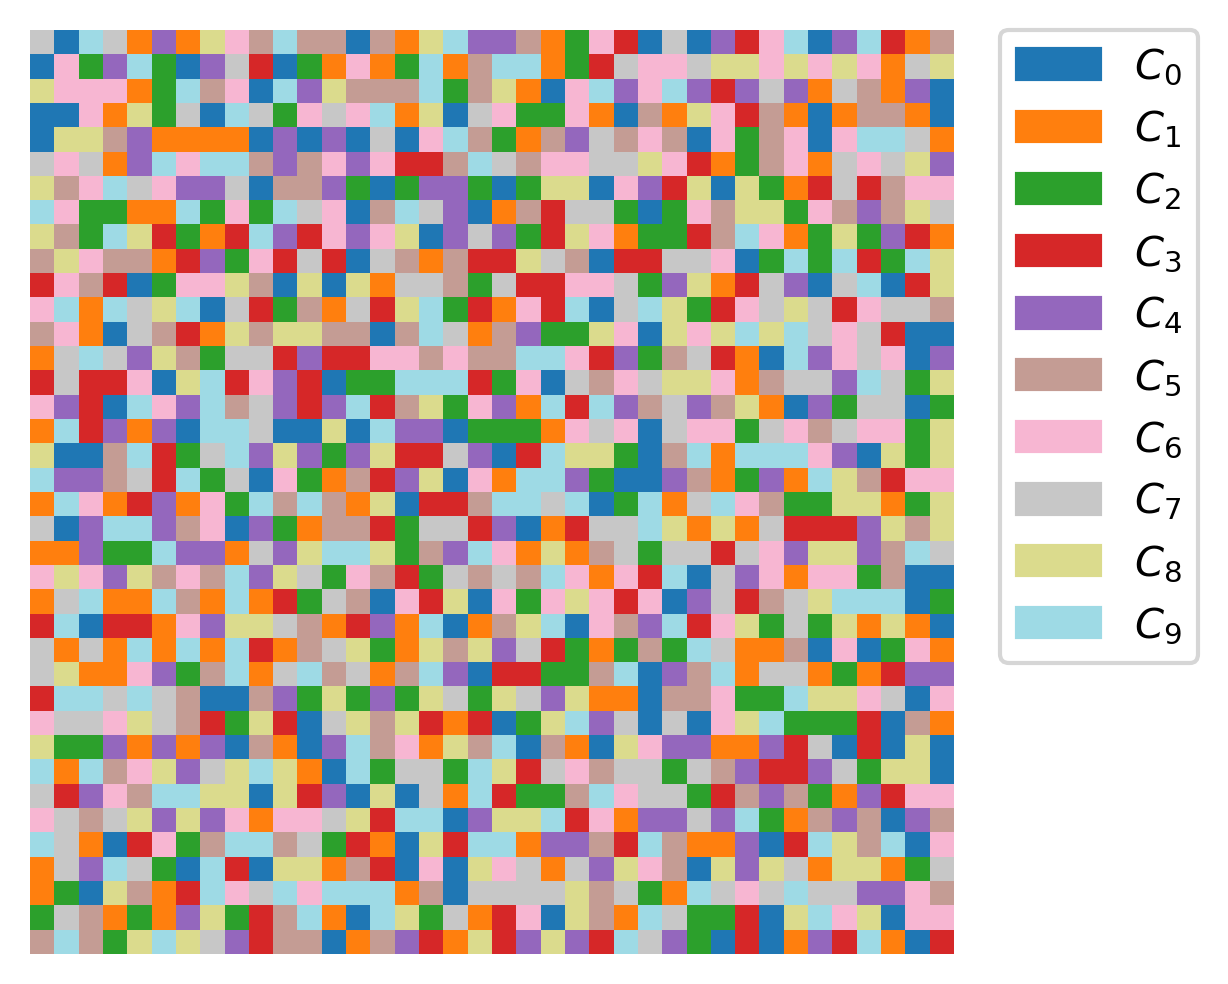

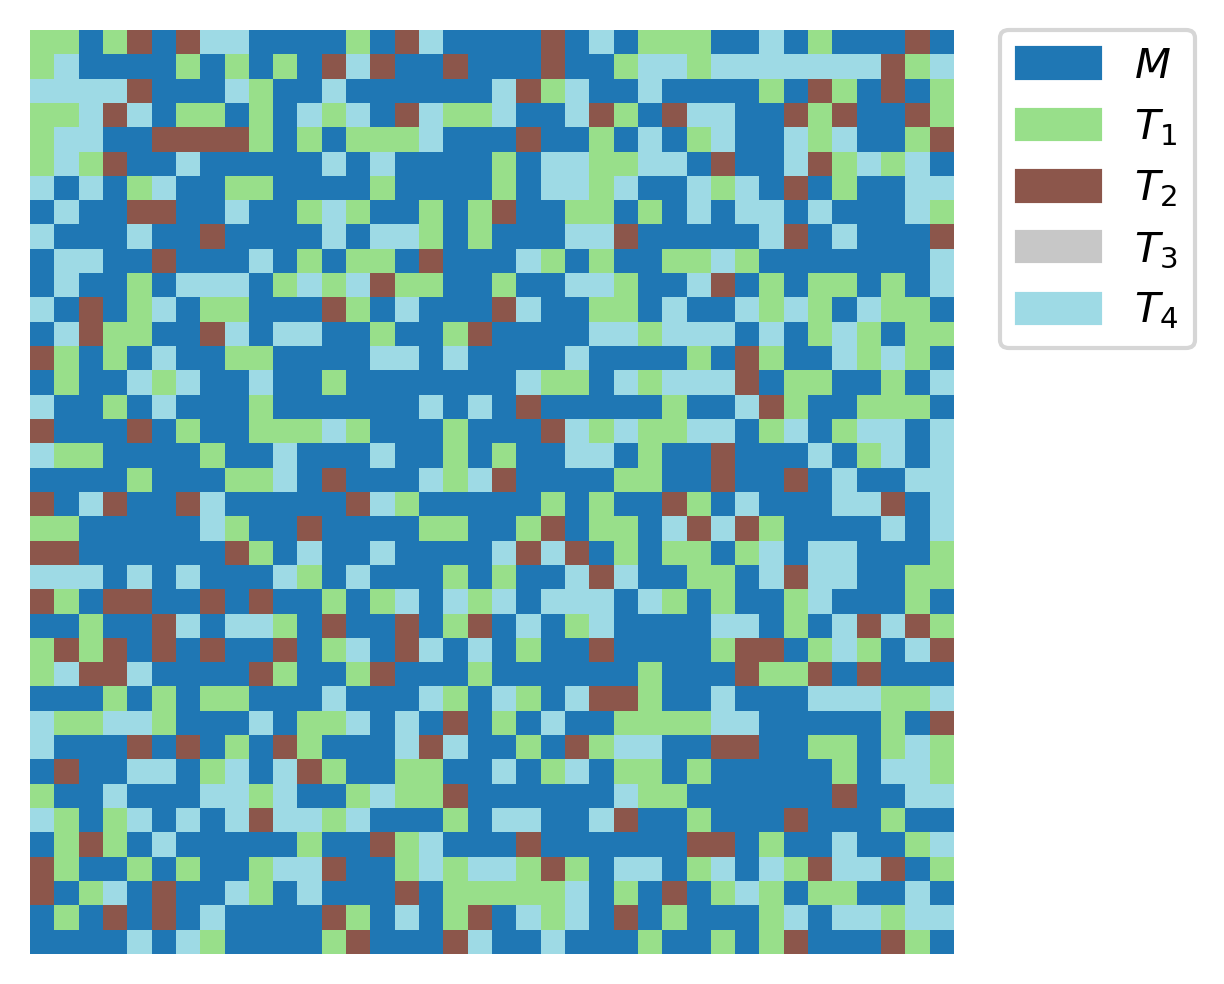

In [120]:
# Declare parameters
#---------------------------------------
n_steps = 10001
nx = 40
T = 1
k = 1
lambda_vol = 0.1 # volume constraint

n_cell_types = 5
cell_type_names = ['$M$'] + [f'$T_{i}$' for i in range(1, n_cell_types)]

n_cell_ids = 10 # at initialization
cell_id_names = [f'$C_{i}$' for i in range(n_cell_ids)]

# Randomly assign cell types to cell ids
random_types = np.random.choice(n_cell_types, n_cell_ids)
id_to_type_dict = {i: random_types[i] for i in range(n_cell_ids)}

equilibrium_area_per_id = nx*nx/n_cell_ids
equilibrium_areas = [equilibrium_area_per_id*random_types[random_types==i].size for i in range(n_cell_types)]
equilbrium_area_by_type = dict(zip(range(n_cell_types), equilibrium_areas))

# Initialize random grid of cell ids
id_grid_0 = np.zeros((nx + 2, nx + 2), dtype=int)
id_grid_0[1:-1, 1:-1] = np.random.choice(n_cell_ids, (nx,nx))


def cellular_pots_model(J):
    # Create new grid
    id_grid = id_grid_0.copy()
    
    for step in range(n_steps):

        # Randomly choose lattice site 
        i, j = np.random.randint(1,nx+1, 2) # exclude boundary
        cell_id = id_grid[i, j]
        cell_type = id_to_type_dict[cell_id]

        # Randomly choose von Neumann neighbor
        distance = np.random.choice([-1, 1], 2)
        neighbor_id = id_grid[i + distance[0], j + distance[1]]
        neighbor_type = id_to_type_dict[neighbor_id]

        # Hamiltonian
        H_vol = compute_h_vol(id_grid, equilbrium_area_by_type, lambda_vol)
        H_bond = compute_h_bond(id_grid, J, i, j, cell_id, cell_type)
        H = H_vol + H_bond
        
        # Probability
        P = np.exp(-H/(k*T))

        # Update grid
        if P > np.random.sample():
            id_grid[i, j] = neighbor_id

    return id_grid[1:-1, 1:-1]

def kronecker_delta(a, b):
    return 1 if a == b else 0

def compute_h_vol(id_grid, equilibrium_area_by_type, lambda_vol):
    h_vol = 0
    ids, counts = np.unique(id_grid, return_counts=True)
    areas = nx*nx/counts
    for id, area in zip(ids, areas):
        cell_type = id_to_type_dict[id]
        h_vol += lambda_vol * (area - equilibrium_area_by_type[cell_type])**2
    return h_vol

def compute_h_bond(id_grid, J, i, j, cell_id, cell_type):
    h_bond = 0
    moore_offsets = np.indices((3, 3)).T.reshape(-1, 2) - 1
    for offset in moore_offsets:
        neighbor_id = id_grid[i + offset[0], j + offset[1]]
        neighbor_type = id_to_type_dict[neighbor_id]
        h_bond += J[cell_type, neighbor_type] * kronecker_delta(cell_id, neighbor_id)
    return h_bond

def plot_ids(id_grid, cell_id_names=cell_id_names):
    '''
    Visualize the matrix of id grid and have distinct colors for each cell id
    '''
    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = fig.add_subplot(111)
    
    cmap = plt.get_cmap('tab20', len(cell_id_names))
    im = ax.matshow(id_grid[1:-1, 1:-1], cmap=cmap)
    ax.axis('off')
    
    colors = [im.cmap(im.norm(i)) for i in range(len(cell_id_names))]
    patches = [mpatches.Patch(color=colors[i], label=cell_id_names[i]) for i in range(len(n_cell_ids_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    return fig

def plot_types(id_grid, cell_type_names=cell_type_names):
    '''
    Visualize the matrix of id grid and have distinct colors for each cell type
    '''
    # Create figures
    fig = plt.figure(figsize=(4,4), dpi=300)
    ax = fig.add_subplot(111)
    cmap = plt.get_cmap('tab20', len(cell_type_names))
    type_grid = np.array([[id_to_type_dict[id] for id in row] for row in id_grid])
    
    im = ax.matshow(type_grid[1:-1, 1:-1], cmap=cmap)
    ax.axis('off')
    
    colors = [im.cmap(im.norm(i)) for i in range(len(cell_type_names))]
    patches = [mpatches.Patch(color=colors[i], label=cell_type_names[i]) for i in range(len(cell_type_names))]
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
    return fig

def generate_J(n, style):
    '''
    Generate example interaction matrix J for n cell types
    '''
    if style == 0:
        J = np.full((n, n), -1) # negative cross-interaction
        np.fill_diagonal(J, 1) # positive self-interaction
    elif style == 1:
        J = np.random.rand(n, n)
    elif style == 2:
        J = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                J[i, j] = np.random.choice([-1, 1])
    elif style == 3:
        J = np.zeros((n, n))
    return J

J = generate_J(n_cell_types, 0)

id_grid = cellular_pots_model(J)
fig = plot_ids(id_grid)
plt.show()
fig = plot_types(id_grid)
plt.show()